In [10]:
from langchain.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma

import os
from dotenv import load_dotenv
from langchain_huggingface import HuggingFaceEmbeddings
from dotenv import load_dotenv
from langchain_groq import ChatGroq
from langchain.chains import RetrievalQA
from langchain_community.retrievers import BM25Retriever
# from langchain.document_loaders import PyMuPDFLoader
from langchain_community.document_loaders import PyPDFLoader

from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Literal

import warnings
warnings.filterwarnings("ignore")

In [5]:
## Load environment variables
load_dotenv()
os.environ["HF_TOKEN"]=os.getenv("HF_TOKEN")

## chat client
llm = ChatGroq(groq_api_key=os.getenv("GROQ_API_KEY_3") ,model="openai/gpt-oss-120b", temperature=0)

embedding_model=HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")


In [11]:
# State definition
class AgentState(TypedDict):
    query: str
    context: str

In [16]:
# PDF loading and vector store
pdf_folder_path = "./pdf_files"
persist_dir = "./optums_chroma_db"

def load_and_split_documents():
    documents = []
    for file_name in os.listdir(pdf_folder_path):
        if file_name.lower().endswith(".pdf"):
            loader = PyPDFLoader(os.path.join(pdf_folder_path, file_name))
            docs = loader.load()
            documents.extend(docs)
    splitter = RecursiveCharacterTextSplitter(chunk_size=3000, chunk_overlap=200)
    return splitter.split_documents(documents)

def setup_chroma_vectorstore():
    if not os.path.exists(persist_dir) or not os.listdir(persist_dir):
        print("🔧 Initializing new Chroma DB...")
        splits = load_and_split_documents()
        vectordb = Chroma.from_documents(
            documents=splits,
            embedding=embedding_model,
            persist_directory=persist_dir
        )
        vectordb.persist()
    return vectordb

vectorstore = setup_chroma_vectorstore()



🔧 Initializing new Chroma DB...


In [22]:
def semantic_retrieval(query, top_k = 3):
    results = vectorstore.similarity_search(query, k=top_k*2)
    unique_results = []
    seen_contents = set()

    for doc in results:
        if doc.page_content not in seen_contents:
            unique_results.append(doc)
            seen_contents.add(doc.page_content)
        if len(unique_results)>=top_k:
            break
    return unique_results

query = "What is Attention Mechanism?"
semantic_results = semantic_retrieval(query)

for i,doc in enumerate(semantic_results,1):
    processed_content = doc.page_content.replace('\n',' ')
    print(f"\n Semantic Result {i}:\n{processed_content}")


 Semantic Result 1:
Attention Visualizations Input-Input Layer5 It is in this spirit that a majority of American governments have passed new laws since 2009 making the registration or voting process more difficult . <EOS> <pad> <pad> <pad> <pad> <pad> <pad> It is in this spirit that a majority of American governments have passed new laws since 2009 making the registration or voting process more difficult . <EOS> <pad> <pad> <pad> <pad> <pad> <pad> Figure 3: An example of the attention mechanism following long-distance dependencies in the encoder self-attention in layer 5 of 6. Many of the attention heads attend to a distant dependency of the verb ‘making’, completing the phrase ‘making...more difficult’. Attentions here shown only for the word ‘making’. Different colors represent different heads. Best viewed in color. 13

 Semantic Result 2:
from [93]. Figure 5: An example of language model training objectives, image from [93]. the attention and the connection of transformer blocks. A

## Hybrid Search

In [26]:
# !pip install rank_bm25

In [25]:
# Define a function to combine BM25 keyword matching with vector similarity for hybrid retrieval
from langchain.schema import Document
def hybrid_retrieval_simple(query, top_k=3):
    """
    Combines semantic and keyword search results for diverse retrieval.
    """

    # Get semantic search results
    semantic_results = vectorstore.similarity_search(query, k=top_k*2)
    semantic_contents = [doc.page_content for doc in semantic_results]

    # Get keyword search results
    documents = [Document(page_content=doc) if isinstance(doc, str) else doc
                 for doc in vectorstore.get()["documents"]]

    bm25_retriever = BM25Retriever.from_documents(documents)
    keyword_results = bm25_retriever.get_relevant_documents(query, k=top_k*2)

    # Take half from semantic results
    final_results = semantic_results[:top_k//2]

    # Add unique keyword results
    for kw in keyword_results:
        if len(final_results) >= top_k:
            break

        if kw.page_content not in semantic_contents:
            final_results.append(kw)

    # Fill remaining spots with semantic results
    remaining_spots = top_k - len(final_results)

    if remaining_spots > 0:
        start_idx = len(final_results)
        final_results.extend(semantic_results[start_idx:start_idx + remaining_spots])

    return final_results


# Test the function



hybrid_results = hybrid_retrieval_simple(
    "How does the Integrated Clinical Environment (ICE) platform support MDOT implementation in healthcare settings?"
)

for i,doc in enumerate(hybrid_results,1):
    processed_content = doc.page_content.replace('\n',' ')
    print(f"\n Hybrid Result {i}:\n{processed_content}")



 Hybrid Result 1:
vice to handle common questions; or applied to generate con- tent for digital platforms like websites, by creating human-like text based on given prompts [424]. Moreover, LLMs play a cru- cial role in data analysis, where they can filter large volumes of text data, summarize key points, and find patterns that would take humans much longer to identify [425]. Despite their wide- ranging applications, it is essential to remember that LLMs, similar to any AI system, are only as good as the data they have been trained on. Medicine: The application of LLMs in the field of medicine is reshaping healthcare delivery and research. For example, LLMs are increasingly used in clinical decision support systems to provide physicians with evidence-based treatment recommen- dations [426, 427, 428]. By analyzing patient data and medical literature, they can help identify potential diagnoses, suggest appropriate tests, and recommend optimal treatment strategies. Moreover, LLMs can also

## Reranking

In [27]:
from langchain_core.messages import AIMessage, HumanMessage

def get_response(prompt):
    messages = [HumanMessage(content=prompt)]
    response = llm.invoke(messages)
    return response.content

In [28]:
# Define function to use OpenAI GPT (via ChatCompletion) to rerank document chunks 
# based on relevance to a query.

def llm_rerank_with_llm(query, retrieved_docs, top_k=3):
    """
    Args:
        query (str): The user's input question.
        retrieved_docs (list): List of Langchain Document objects retrieved from ChromaDB.
        top_k (int): Number of top chunks to return.

    Returns:
        list: Sorted list of the most relevant chunks, based on GPT scoring.
    """

    # Step 1: Prepare the ranking prompt
    prompt = (
        "You are helping rank document chunks based on how well they answer this question.\n\n"
        f"Question: {query}\n\n"
        "Here are the chunks:\n\n"
    )

    for i, doc in enumerate(retrieved_docs):
        prompt += f"Chunk {i+1}:\n{doc.page_content.strip()}\n\n"

    prompt += (
        f"Please rank the top {top_k} chunks in order of relevance. "
        "Respond only like this: 'Chunk 3, Chunk 1, Chunk 5'"
    )

    # Step 2: Call GPT for reranking
    gpt_output = get_response(prompt)
    print("GPT Rerank Output:\n", gpt_output)

    # Step 3: Extract chunk numbers from the output
    chunk_order = [
        int(s.strip().split()[-1]) - 1
        for s in gpt_output.split(",")
        if s.strip().startswith("Chunk")
    ]

    # Step 4: Return sorted chunk objects
    reranked_docs = [retrieved_docs[i] for i in chunk_order if i < len(retrieved_docs)]

    return reranked_docs

reranked_results = llm_rerank_with_llm(query,hybrid_results)

for i,doc in enumerate(reranked_results,1):
    processed_content = doc.page_content.replace('\n',' ')
    print(f"\n Hybrid Result {i}:\n{processed_content[:300]}")


GPT Rerank Output:
 Chunk 3, Chunk 2, Chunk 1

 Hybrid Result 1:
make LLMs aware of the available low-level task operations. LLM (Say) builds a high-level plan to complete the task and a learned affordance function (Can) explores the possibility of executing the plan in the real world. SayCan uses RL to train the language-conditioned affordance function. PaLM-E e

 Hybrid Result 2:
Direct preference optimization: Your language model is secretly a re- ward model, arXiv preprint arXiv:2305.18290 (2023). 16 [159] H. Dong, W. Xiong, D. Goyal, R. Pan, S. Diao, J. Zhang, K. Shum, T. Zhang, Raft: Reward ranked finetuning for generative foundation model alignment, arXiv preprint arXiv

 Hybrid Result 3:
vice to handle common questions; or applied to generate con- tent for digital platforms like websites, by creating human-like text based on given prompts [424]. Moreover, LLMs play a cru- cial role in data analysis, where they can filter large volumes of text data, summarize key points, and fin

In [52]:
def rag_agent(state: AgentState) -> AgentState:
    hybrid_results = hybrid_retrieval_simple(state["query"])
    reranked_results = llm_rerank_with_llm(state["query"],hybrid_results)

    context = "\n\n---\n\n".join(doc.page_content for doc in reranked_results)
    return {"query": state["query"], "context": context}

def summarization_agent(state: AgentState) -> AgentState:
    prompt = f"""Query: {state['query']}

Context:
{state['context']}

Summarize the above in a clear, concise, factual response."""
    messages = [
        HumanMessage(content=prompt),
    ]
    response = llm.invoke(messages)
    return {
        "query": state["query"],
        "context": response.content.strip()
    }

In [53]:
from langgraph.checkpoint.memory import MemorySaver

builder = StateGraph(AgentState)
builder.add_node("rag", rag_agent)
builder.add_node("summarize", summarization_agent)




builder.add_edge(START, "rag")
builder.add_edge("rag","summarize")
builder.add_edge("summarize", END)


memory = MemorySaver()
graph = builder.compile(checkpointer=memory) ## memory checkpointer

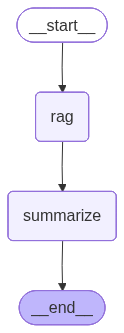

In [54]:
from IPython.display import display, Image, Markdown


display(Image(graph.get_graph().draw_mermaid_png()))

In [55]:
def call_support_agent(agent, prompt, user_session_id, verbose=False):
    events = agent.stream(
        {"query": prompt}, # initial state of the agent
        {"configurable": {"thread_id": user_session_id}},
        stream_mode="values",
    )

    print('Running Agent. Please wait...')
    for event in events:
        if verbose:
                print(event)

    display(Markdown(event['context']))

In [56]:
uid = 'subham002'
query = "What is Attention mechanism?"
call_support_agent(agent=graph,
                   prompt=query,
                   user_session_id=uid,
                   verbose=True)

Running Agent. Please wait...
{'query': 'What is Attention mechanism?'}
GPT Rerank Output:
 Chunk 2, Chunk 1, Chunk 3
{'query': 'What is Attention mechanism?', 'context': '2. Background\nWe provide the relevant background to understand the fun-\ndamentals related to LLMs in this section. We briefly discuss\nnecessary components in LLMs and refer the readers interested\nin details to the original works.\n2.1. Tokenization\nTokenization [59] is an essential pre-processing step in\nLLM training that parses the text into non-decomposing units\ncalled tokens. Tokens can be characters, subwords [60], sym-\nbols [61], or words, depending on the tokenization process.\nSome of the commonly used tokenization schemes in LLMs\ninclude wordpiece [62], byte pair encoding (BPE) [61], and un-\nigramLM [60]. Readers are encouraged to refer to [63] for a\ndetailed survey.\n2.2. Encoding Positions\nThe transformer processes input sequences in parallel and\nindependently of each other. Moreover, the atten

**Attention Mechanism (in Transformers and LLMs)**  

- **Purpose:**  
  Assigns a weight to each input token according to its relevance for producing the current output token, allowing the model to focus on the most informative parts of the sequence.

- **Core Computation:**  
  1. **Linear projections** of the input embeddings produce three vectors for every token:  
     - **Query (Q)** – what the model is looking for.  
     - **Key (K)** – how each token can be matched.  
     - **Value (V)** – the information to be aggregated.  
  2. **Attention scores** are obtained by the dot‑product of a query with all keys ( \(QK^{\top}\) ).  
  3. The scores are scaled, optionally combined with positional bias, and passed through a soft‑max to become **attention weights**.  
  4. Each weight multiplies its corresponding value vector; the weighted sum yields the token’s new representation.

- **Main Variants:**  
  - **Self‑Attention:** Q, K, V come from the same sequence (used in both encoder and decoder layers).  
  - **Cross‑Attention:** Q comes from the decoder while K and V come from the encoder (typical in encoder‑decoder models).  
  - **Sparse Attention:** Reduces the quadratic \(O(n^{2})\) cost by limiting the attention pattern (e.g., sliding windows).  
  - **Flash Attention:** Optimizes memory traffic on GPUs by tiling the computation, achieving faster and more memory‑efficient attention.

- **Interaction with Position Information:**  
  Since raw attention is permutation‑invariant, positional encodings (absolute, relative, Alibi, RoPE, etc.) are added to token embeddings or incorporated into the attention scores so the model can distinguish token order and capture long‑distance dependencies.

- **Effect in Practice:**  
  Attention heads often learn to track linguistic relations such as subject‑verb agreement, coreference, or phrase completion. Visualizations (e.g., Figure 3 in the cited text) show heads attending to distant tokens like the verb “making” and its complement “more difficult,” illustrating how the mechanism captures long‑range dependencies.  

In short, the attention mechanism is a differentiable way for a transformer‑based LLM to weigh and combine information from all positions in the input, enabling flexible, context‑aware representations that drive the model’s performance.

In [57]:
uid = 'subham002'
query = "What is the purpose of Multi-Head Attention in transformers?"
call_support_agent(agent=graph,
                   prompt=query,
                   user_session_id=uid,
                   verbose=True)

Running Agent. Please wait...
{'query': 'What is the purpose of Multi-Head Attention in transformers?', 'context': '**Attention Mechanism (in Transformers and LLMs)**  \n\n- **Purpose:**  \n  Assigns a weight to each input token according to its relevance for producing the current output token, allowing the model to focus on the most informative parts of the sequence.\n\n- **Core Computation:**  \n  1. **Linear projections** of the input embeddings produce three vectors for every token:  \n     - **Query (Q)** – what the model is looking for.  \n     - **Key (K)** – how each token can be matched.  \n     - **Value (V)** – the information to be aggregated.  \n  2. **Attention scores** are obtained by the dot‑product of a query with all keys (\u202f\\(QK^{\\top}\\)\u202f).  \n  3. The scores are scaled, optionally combined with positional bias, and passed through a soft‑max to become **attention weights**.  \n  4. Each weight multiplies its corresponding value vector; the weighted sum yi

**Purpose of Multi‑Head Attention**

Multi‑Head Attention (MHA) is a core component of the Transformer that extends a single attention operation in three complementary ways:

| What it does | Why it matters |
|--------------|----------------|
| **Projects Q, K, V into h different sub‑spaces** (each head uses its own learned linear projections) | Each head can focus on a distinct set of features or “representation sub‑space” of the tokens, rather than forcing a single head to capture everything. |
| **Runs the scaled‑dot‑product attention in parallel on all heads** | The model can attend to many patterns simultaneously (e.g., syntactic relations, long‑range dependencies, positional cues) and combine them later. |
| **Concatenates the heads and linearly projects back to the model dimension** | The diverse information from all heads is merged into a single representation of the same size as the original model ( d_model ), preserving the overall computational budget. |

### Key Benefits

1. **Richer expressiveness** – By attending to multiple sub‑spaces, the network can learn different types of relationships (e.g., “subject‑verb”, “coreference”, “local n‑gram”) at the same layer.
2. **Mitigates averaging effect** – A single attention head would average over all cues, potentially washing out useful signals. Multiple heads keep those signals separate before they are combined.
3. **Constant computational cost** – Because each head works on a reduced dimension ( d_k = d_v = d_model / h ), the total cost of MHA is roughly the same as a single‑head attention with full dimensionality.
4. **Facilitates parallelism** – All heads are computed simultaneously using matrix multiplications, fitting the Transformer’s fully parallel architecture.

In short, Multi‑Head Attention lets the Transformer **jointly attend to information from different representation subspaces at different positions**, giving the model the capacity to capture a variety of dependencies while keeping the computation efficient and fully parallelizable.